# Convolutional Autoencoder Training for Anomaly Detection @ L1Trigger

# Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

# Input files reading

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

Zerobias and MC signal files:

In [2]:
ZeroBias = np.concatenate((h5py.File('bkg/ZeroBias_0.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_1.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_2.h5', 'r')['CaloRegions'][()]))
ZeroBias = ZeroBias.astype(dtype = 'float32').reshape(-1, 18, 14, 1)
print('ZeroBias shape: ' + str(ZeroBias.shape))

MC_files = []
MC_files.append('bkg/110X/QCD_0.h5')#i=0
#MC_files.append('bkg/110X/QCD_1.h5')
#MC_files.append('bkg/110X/QCD_2.h5')
MC_files.append('bkg/120X/SingleNeutrino_E-10_0.h5')#i=1
#MC_files.append('bkg/120X/SingleNeutrino_E-10_1.h5')
#MC_files.append('bkg/120X/SingleNeutrino_E-10_2.h5')
MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_0.h5')#i=2
#MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_1.h5')
#MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_2.h5')

MC_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=3
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
MC_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=13
MC_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=23
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=33
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV-pythia814TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=43
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=51

MC = []
AcceptanceFlag = []
for i in range(len(MC_files)):
    MC.append(h5py.File(MC_files[i], 'r')['CaloRegions'][()].astype(dtype = 'float32'))
    MC[i] = MC[i].reshape(-1, 18, 14, 1)
    #Read acceptance flag in MC signals
    if i > 2:
        AcceptanceFlag.append(h5py.File(MC_files[i], 'r')['AcceptanceFlag'][()])
    else:
        AcceptanceFlag.append(np.ones((MC[i].shape[0])))
    
MC[0] = MC[0][:100000,:,:,:]#QCD
MC[1] = MC[1][:100000,:,:,:]#SingleNu_E10
MC[2] = MC[2][:100000,:,:,:]#SingleNu_Pt2To20

'''
#/nfs_scratch/dasu/2022-02-04/L1TSignalZerobiasMixer/cms-vbfh.csv
vbf = pd.read_csv('cms-vbfh.csv')
vbf.columns = ['eta','phi','et','pos','ebit','tbit']
vbf = vbf[251:]

event_col = []
for i in range(round(vbf.shape[0]/252)):
    for j in range(252):
        event_col.append(i)
        
vbf['event'] = event_col
vbf = vbf.drop(['pos','ebit','tbit'],axis=1)
vbf = vbf.sort_values(by=['event', 'phi', 'eta'], ascending = [True, True, True])
vbf = vbf.reindex(columns=['event','phi','eta','et'])
vbf = vbf.drop(['event'],axis=1)
vbf = vbf.to_numpy()
vbf = vbf.reshape((-1,18,14,3))
vbf = vbf[:,:,:,2]
vbf = vbf.reshape((-1,18,14,1))
vbf.shape
MC_files.append('/nfs_scratch/dasu/2022-02-04/L1TSignalZerobiasMixer/cms-vbfh.csv')
MC.append(vbf)
'''

#Throw away MC signal events that failed to pass the acceptance cuts
acceptance_filter = []
for i in range(len(MC_files)):
    acceptance_filter.append([])
    for j in range(MC[i].shape[0]):
        if AcceptanceFlag[i][j] == 1:
            acceptance_filter[i].append(True)
        else:
            acceptance_filter[i].append(False)
    MC[i] = MC[i][acceptance_filter[i],:,:,:]
    print('i = ' + str(i) + ': ' + str(MC[i].shape) + '; accepted ' + str(np.round(np.mean(AcceptanceFlag[i]), 4)))

ZeroBias shape: (315766, 18, 14, 1)
i = 0: (100000, 18, 14, 1); accepted 1.0
i = 1: (100000, 18, 14, 1); accepted 1.0
i = 2: (100000, 18, 14, 1); accepted 1.0
i = 3: (49931, 18, 14, 1); accepted 0.9986
i = 4: (39851, 18, 14, 1); accepted 1.0
i = 5: (34589, 18, 14, 1); accepted 0.8647
i = 6: (11334, 18, 14, 1); accepted 0.8718
i = 7: (35599, 18, 14, 1); accepted 0.89
i = 8: (291352, 18, 14, 1); accepted 0.9712
i = 9: (29879, 18, 14, 1); accepted 0.996
i = 10: (279275, 18, 14, 1); accepted 0.9597
i = 11: (1853, 18, 14, 1); accepted 0.9995
i = 12: (38011, 18, 14, 1); accepted 0.9997
i = 13: (6279, 18, 14, 1); accepted 0.999
i = 14: (49993, 18, 14, 1); accepted 0.9999
i = 15: (49845, 18, 14, 1); accepted 0.9969
i = 16: (49969, 18, 14, 1); accepted 0.9994
i = 17: (273519, 18, 14, 1); accepted 0.9117
i = 18: (99843, 18, 14, 1); accepted 0.9984
i = 19: (99323, 18, 14, 1); accepted 0.9932
i = 20: (39987, 18, 14, 1); accepted 1.0
i = 21: (39985, 18, 14, 1); accepted 1.0
i = 22: (31505, 18, 14, 

Throw away events with max pt > 1023 GeV, since the calo system cannot produce more than that (input pt is 10 bits).

In [3]:
filter1023_zb = []
for i in range(ZeroBias.shape[0]):
    if ZeroBias[i,:,:,0].max() > 1023:
        filter1023_zb.append(False)
    else:
        filter1023_zb.append(True)
ZeroBias = ZeroBias[filter1023_zb,:,:,:]
print('ZeroBias shape = ' + str(ZeroBias.shape) + '; fraction left = ' + str(round(ZeroBias.shape[0]/len(filter1023_zb),4)))

filter1023_mc = []
for i in range(len(MC_files)):
    filter1023_mc.append([])
    for j in range(MC[i].shape[0]):
        if MC[i][j,:,:,0].max() > 1023:
            filter1023_mc[i].append(False)
        else:
            filter1023_mc[i].append(True)
    MC[i] = MC[i][filter1023_mc[i],:,:,:]
    print('i = ' + str(i) + ': ' + str(MC[i].shape) + '; fraction left = ' + str(round(MC[i].shape[0]/len(filter1023_mc[i]),4)))

ZeroBias shape = (315766, 18, 14, 1); fraction left = 1.0
i = 0: (89972, 18, 14, 1); fraction left = 0.8997
i = 1: (100000, 18, 14, 1); fraction left = 1.0
i = 2: (100000, 18, 14, 1); fraction left = 1.0
i = 3: (49560, 18, 14, 1); fraction left = 0.9926
i = 4: (39329, 18, 14, 1); fraction left = 0.9869
i = 5: (34574, 18, 14, 1); fraction left = 0.9996
i = 6: (11329, 18, 14, 1); fraction left = 0.9996
i = 7: (35583, 18, 14, 1); fraction left = 0.9996
i = 8: (291258, 18, 14, 1); fraction left = 0.9997
i = 9: (29840, 18, 14, 1); fraction left = 0.9987
i = 10: (279195, 18, 14, 1); fraction left = 0.9997
i = 11: (1774, 18, 14, 1); fraction left = 0.9574
i = 12: (36548, 18, 14, 1); fraction left = 0.9615
i = 13: (5956, 18, 14, 1); fraction left = 0.9486
i = 14: (47706, 18, 14, 1); fraction left = 0.9543
i = 15: (49778, 18, 14, 1); fraction left = 0.9987
i = 16: (49646, 18, 14, 1); fraction left = 0.9935
i = 17: (273483, 18, 14, 1); fraction left = 0.9999
i = 18: (99749, 18, 14, 1); fraction 

The MC samples are clean, so we need to overlay them with ZB to be more realistic before doing any training/testing. It can be achieved by simple region-by-region addition between the two: MC(i,j) = MC(i,j) + ZB(i,j), where the ZB can be chosen at random per MC event.

In [4]:
np.random.seed(0)
MC_zb = []
for i in range(len(MC)):
    MC_zb.append(np.empty((MC[i].shape[0], 18, 14, 1)))
    ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = MC[i].shape[0])
    for j in range(MC[i].shape[0]):
        MC_zb[i][j, :, :, 0] = ZeroBias[ZB_random_event[j], :, :, 0] + MC[i][j, :, :, 0]

Take a look at the calo region plots before and after the overlay,

where n = 0 (QCD), 1 (SingleNu_E10), 2 (SingleNu_Pt2To20), 3... (signals)

In [ ]:
n = 5
for i in range(40,50):
    fig, ax = plt.subplots(figsize = (10,10))
    print(str(MC_files[n]))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(MC[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(MC_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC+ZB')
    
    plt.show()

Take a look at some ZB statistics.

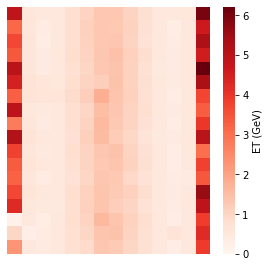

In [5]:
ZB_mean = np.mean(ZeroBias, axis = 0)

fig, ax = plt.subplots(figsize = (10,10))
ax = plt.subplot(2, 2, 1)
ax = sns.heatmap(ZB_mean.reshape(18, 14), vmin = 0, vmax = ZB_mean.max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

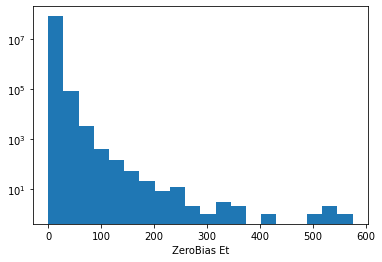

Mean ZeroBias pT = 1.227905


In [6]:
plt.hist(ZeroBias.reshape((-1)), bins = 20, log = True)
plt.xlabel("ZeroBias Et")
plt.show()

print('Mean ZeroBias pT = ' + str(np.mean(ZeroBias.reshape(-1))))

Very few ZB events might have high pt regions since they could contain signal, do we want to put a cut on ZB before training?

In [ ]:
pt_filter = []
for i in range(ZeroBias.shape[0]):
    if ZeroBias[i,:,:,0].max() < 30.0:
        pt_filter.append(True)
    else:
        pt_filter.append(False)
ZeroBias_ptcut = ZeroBias[pt_filter,:,:,:]

# Hyperparameter searching (no quantization here)

If we want to train with custom loss functions.

In [ ]:
import tensorflow.keras.backend as K
def custom_loss_for_train():
    def func(y_true, y_pred):
        #MSE(output, input)
        loss = K.mean((y_pred - y_true)**2, axis = [1, 2, 3])
        
        #MSE(output, mean ZB)
        #loss = K.mean((y_pred - ZB_mean)**2, axis = [1, 2, 3])
        
        #MSE(output, 0) for denoising
        #loss = K.mean(y_pred**2, axis = [1, 2, 3])
        
        return loss
    return func

Hypermodel for convolutional autoencoder (usually a teacher model for Knowledge Distillation later).

In [ ]:
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_1',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.AveragePooling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_2',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_3',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.UpSampling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_4',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', strides = 1, padding = 'same'))
    hp_model.compile(optimizer = 'adam', loss = custom_loss_for_train())
    return hp_model

Hypermodel for shallowly dense (usually a student model for Knowledge Distillation later).

In [ ]:
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(tf.keras.layers.Flatten())
    hp_model.add(tf.keras.layers.Dense(units = hp.Int('units_1',
                                                      min_value = 10,
                                                      max_value = 40,
                                                      step = 2),
                                       activation = 'relu'))
    hp_model.add(tf.keras.layers.Dropout(rate = 0.3))
    hp_model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    hp_model.compile(optimizer = 'adam', loss = 'mse')
    return hp_model

Set configuration for tuner (Hyperband).

In [ ]:
tuner = Hyperband(hypermodel,
                 objective = 'val_loss',
                 max_epochs = 20,
                 factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                 hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                 seed = 10,
                 directory = 'hypertuning',
                 project_name = 'tune',
                 overwrite = True)

Partition the dataset into train/val/test sets.

In [7]:
X = ZeroBias

train_ratio = 0.5
val_ratio = 0.15
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

Run the search. Mind the label when training for reconstruction or something else.

In [ ]:
tuner.search(X_train, X_train,
            epochs = 20,
            validation_data = (X_val, X_val),
            batch_size = 256)

Show the best models.

In [ ]:
tuner.results_summary(num_trials = 3)

Take one of them for later use.

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

# Convolutional autoencoder

Convolutional autoencoder to be trained for input reconstruction (to be used as a teacher model for Knowledge Distillation later).

The encoder part, transforming the (18, 14) region input into a smaller latent space.

In [ ]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(21, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_input)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(19, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(1, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

The decoder part, reconstructing from latent space back to the (18, 14) region input. Note the Conv2DTranspose is not yet supported in hls4ml, but ok to use if it is going to be distilled to another network. 

In [ ]:
decoding = layers.Conv2D(25, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2D(25, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

In [ ]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

# Dense model

Fully connected dense model to be trained for input reconstruction (less useful since region correlation is lost to some degree in the Flatten layer).

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dense(20 , activation = 'relu'))
model.add(tf.keras.layers.Dense(20 , activation = 'relu'))
model.add(tf.keras.layers.Dense(252 , activation = 'sigmoid'))
model.add(tf.keras.layers.Reshape((18, 14, 1)))
model.summary()
model.compile(optimizer = 'adam', loss = 'mse')

# De-noising model (De-ZeroBias model)

Convolutional autoencoder to be trained for ZB pattern removal. Experimental and for fun only.

In [ ]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_input)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(2, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

In [ ]:
decoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'sigmoid', strides = 1, padding = 'same')(decoding)

In [ ]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
#model.compile(optimizer = 'adam', loss = 'mse')

# Training

Partition the dataset into train/val/test sets.

In [ ]:
X = ZeroBias

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 1234)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 1234)

!!! Only for de-noising model. Preparation of noisy and clean training data.

In [ ]:
np.random.seed(0)

RandomTowers = np.zeros((ZeroBias.shape[0], 18, 14, 1))

random_phi1 = np.random.randint(low = 1, high = 17, size = np.int(RandomTowers.shape[0]/2))
random_eta1 = np.random.randint(low = 1, high = 13, size = np.int(RandomTowers.shape[0]/2))
random_pt1 = np.random.randint(low = 30, high = 100, size = np.int(RandomTowers.shape[0]/2))
random_phi2 = np.random.randint(low = 1, high = 17, size = np.int(RandomTowers.shape[0]/2))
random_eta2 = np.random.randint(low = 1, high = 13, size = np.int(RandomTowers.shape[0]/2))
random_pt2 = np.random.randint(low = 30, high = 100, size = np.int(RandomTowers.shape[0]/2))

for i in range(np.int(RandomTowers.shape[0]/2)):
    RandomTowers[i, random_phi1[i], random_eta1[i], 0] = random_pt1[i]
    RandomTowers[i, random_phi1[i]+1, random_eta1[i]+1, 0] = random_pt2[i]
    RandomTowers[i, random_phi2[i], random_eta2[i], 0] = random_pt2[i]
    RandomTowers[i, random_phi2[i]+1, random_eta2[i], 0] = random_pt1[i]

Xnoise = 3*ZeroBias 
Xclean = ZeroBias

train_ratio = 0.8
val_ratio = 0.18
test_ratio = 1 - train_ratio - val_ratio

Xnoise_train_val, Xnoise_test = train_test_split(Xnoise, test_size = test_ratio, random_state = 123)
Xnoise_train, Xnoise_val = train_test_split(Xnoise_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

Xclean_train_val, Xclean_test = train_test_split(Xclean, test_size = test_ratio, random_state = 123)
Xclean_train, Xclean_val = train_test_split(Xclean_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

!!! Only for de-noising model. Plot and compare the noisy and clean training data.

In [ ]:
for i in range(40,50):
    fig, ax = plt.subplots(figsize = (10,10))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(Xnoise_train[i,:,:,0].reshape(18, 14), vmin = 0, vmax = Xnoise_train[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('X_noise')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(Xclean_train[i,:,:,0].reshape(18, 14), vmin = 0, vmax = Xnoise_train[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('X_clean')
    
    plt.show()

Run the training. Mind the label when training for reconstruction or something else.

In [ ]:
history = model.fit(X_train, X_train,
                    epochs = 80,
                    validation_data = (X_val, X_val),
                    batch_size = 256,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                    ])

Plot loss vs epoch.

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# Saving/loading trained models

In [ ]:
model.save('saved_models/teacher/')

In [ ]:
model_student.save('saved_models/student_quantized/')

In [8]:
model = tf.keras.models.load_model('saved_models/teacher')
model.summary()

2022-05-30 20:33:45.356181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 20:33:45.356371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 18, 14, 21)        210       
                                                                 
 average_pooling2d (AverageP  (None, 9, 7, 21)         0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 7, 19)          3610      
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 7, 1)           172       
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 7, 25)          250       
                             

In [ ]:
model_student = tf.keras.models.load_model('saved_models/student_quantized')
model_student.summary()

In [149]:
qmodel.save('saved_models/qmodel/')

INFO:tensorflow:Assets written to: saved_models/qmodel/assets


INFO:tensorflow:Assets written to: saved_models/qmodel/assets


In [150]:
qmodel = tf.keras.models.load_model('saved_models/qmodel')
qmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 18, 14, 1)]       0         
                                                                 
 Flatten (Flatten)           (None, 252)               0         
                                                                 
 Dense_1 (QDense)            (None, 7)                 1764      
                                                                 
 batch_normalization_1 (QBat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 Activation_1 (QActivation)  (None, 7)                 0         
                                                                 
 Out (QDense)                (None, 1)                 7         
                                                           

# Loss distribution

Feed all datasets into the trained model to compute prediction outputs.

In [9]:
X_train_predict = model.predict(X_train)
X_val_predict = model.predict(X_val)
X_test_predict = model.predict(X_test)
MC_zb_predict = []
for i in range(len(MC_zb)):
    MC_zb_predict.append(model.predict(MC_zb[i]))

2022-05-30 20:33:50.918322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-30 20:33:51.070568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 20:34:51.497806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Define loss function to use for inference.

In [10]:
def custom_loss_for_pred(y_true, y_pred, choice):
    #Simple MSE
    if choice == 0:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 2, 3))
        return loss
    
    #Simple MSE for de-noising model
    if choice == 1:
        loss = np.mean(y_pred**2, axis = (1, 2, 3))
        return loss
    
    #Same as custom_loss_for_train
    if choice == 2:
        loss_mse = np.mean((y_pred - y_true)**2, axis = (1, 2, 3))
        #loss_reg = np.mean((y_pred - ZB_mean)**2, axis = (1, 2, 3))
        loss_reg = np.mean(y_pred**2, axis = (1, 2, 3))
        loss = loss_mse + 0.2 * loss_reg
        return loss
    
    #Different weights in eta
    if choice == 3:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 3))
        scale = np.array([0.5, 1, 2, 4, 6, 8, 10, 10, 8, 6, 4, 2, 1, 0.5])
        loss = loss * scale
        loss = np.mean(loss, axis = 1)
        return loss

Compute loss for all samples.

In [11]:
loss_choice = 0

X_train_loss = custom_loss_for_pred(X_train, X_train_predict, loss_choice)
X_val_loss = custom_loss_for_pred(X_val, X_val_predict, loss_choice)
X_test_loss = custom_loss_for_pred(X_test, X_test_predict, loss_choice)

MC_zb_loss = []
for i in range(len(MC_zb)):
    MC_zb_loss.append(custom_loss_for_pred(MC_zb[i], MC_zb_predict[i], loss_choice))

Plot loss distributions.

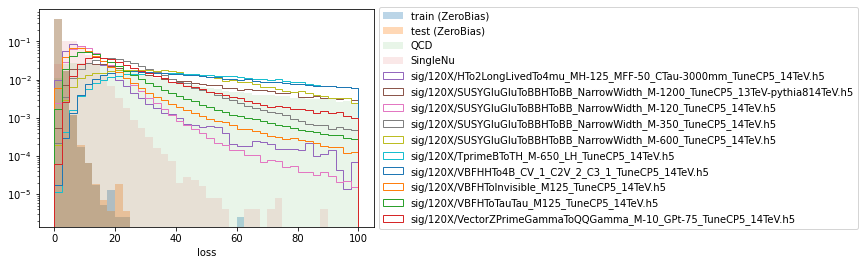

In [12]:
nbins = 40
rmin = 0
rmax = 100
plt.hist(X_train_loss, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_loss, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(MC_zb_loss[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_zb_loss[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(40,50):
    plt.hist(MC_zb_loss[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# Comparison between original and reconstructed inputs

In [ ]:
#Original vs Reconstructed
show_ZB = True
#show_ZB = False
n = 19
for i in range(580,590):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_zb_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(MC_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(MC_zb_predict[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(np.absolute(MC_zb_predict[n][i,:,:,0] - MC_zb[n][i,:,:,0]).reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

# Knowledge Distillation (+ quantizing with QKeras)

In [ ]:
from qkeras import *

Construct student model without quantization.

In [13]:
x_in = layers.Input(shape = (18, 14, 1), name = "In")
x = layers.Flatten(name = "Flatten")(x_in)
x = layers.Dense(15, use_bias = False, name = "Dense_1")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu', name = "Activation_1")(x)
x = layers.Dense(1, name = "Out")(x)

model_student = tf.keras.models.Model(x_in, x)
model_student.summary()
model_student.compile(optimizer = 'adam', loss = 'mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 18, 14, 1)]       0         
                                                                 
 Flatten (Flatten)           (None, 252)               0         
                                                                 
 Dense_1 (Dense)             (None, 15)                3780      
                                                                 
 batch_normalization (BatchN  (None, 15)               60        
 ormalization)                                                   
                                                                 
 Activation_1 (Activation)   (None, 15)                0         
                                                                 
 Out (Dense)                 (None, 1)                 16        
                                                             

Construct student model with pre-defined quantization configuration.

In [ ]:
#For quantization-aware training
x_in = layers.Input(shape = (18, 14, 1))
x = layers.Flatten()(x_in)
x = QDense(26,
           kernel_quantizer = quantized_bits(10, 5, 1),
           bias_quantizer = quantized_bits(6, 3, 1))(x)
x = QActivation('quantized_relu(bits=10, integer=5)')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.3)(x)
x = QDense(1,
           kernel_quantizer = quantized_bits(10, 5, 1),
           bias_quantizer = quantized_bits(6, 3, 1))(x)
x = QActivation('quantized_relu(bits=10, integer=6)')(x)

model_student = tf.keras.models.Model(x_in, x)
model_student.summary()
model_student.compile(optimizer = 'adam', loss = 'mse')

Train the student model with knowledge distilled from a pre-trained teacher model.

In [14]:
history_student = model_student.fit(X_train, X_train_loss,
                                    epochs = 50,
                                    validation_data = (X_val, X_val_loss),
                                    batch_size = 1024,
                                    callbacks = [
                                        #tensorboard_callback,
                                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                                    ])

Epoch 1/50
  1/155 [..............................] - ETA: 2:14 - loss: 2.5582

2022-05-30 20:45:43.398470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 2s 9ms/step - loss: 0.5672 - val_loss: 0.2476
Epoch 2/50
 12/155 [=>............................] - ETA: 0s - loss: 0.2064

2022-05-30 20:45:44.787952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 1s 5ms/step - loss: 0.1921 - val_loss: 0.1785
Epoch 3/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1686 - val_loss: 0.1628
Epoch 4/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1578 - val_loss: 0.1555
Epoch 5/50
155/155 [==============================] - 1s 7ms/step - loss: 0.1503 - val_loss: 0.1529
Epoch 6/50
155/155 [==============================] - 1s 6ms/step - loss: 0.1444 - val_loss: 0.1592
Epoch 7/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1400 - val_loss: 0.1459
Epoch 8/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1369 - val_loss: 0.1447
Epoch 9/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1337 - val_loss: 0.1407
Epoch 10/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1323 - val_loss: 0.1405
Epoch 11/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1300 - val_loss: 0.1397
Epoch 12/

Plot loss vs epoch.

Text(0, 0.5, 'Loss')

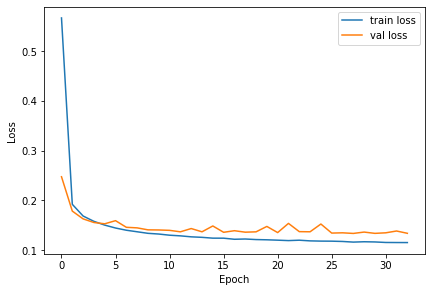

In [15]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history_student.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history_student.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

Feed all datasets into the trained model to compute prediction outputs.

In [16]:
X_train_predict_student = model_student.predict(X_train)
X_test_predict_student = model_student.predict(X_test)
MC_zb_predict_student = []
for i in range(len(MC_zb)):
    MC_zb_predict_student.append(model_student.predict(MC_zb[i]))

2022-05-30 20:46:19.804448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 20:46:35.525084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Plot loss distributions.

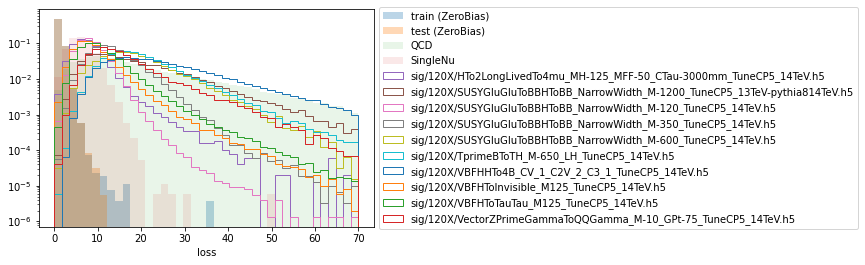

In [17]:
nbins = 40
rmin = 0
rmax = 70
plt.hist(X_train_predict_student, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_predict_student, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(MC_zb_predict_student[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_zb_predict_student[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(40,50):
    plt.hist(MC_zb_predict_student[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# Knowledge Distillation (+ quantizing with AutoQKeras)

In [18]:
from qkeras import *
from qkeras.autoqkeras import *

In [109]:
def metric_for_autoqk(y_true, y_pred):
    loss = 1.5 - tf.reduce_mean(tf.square(y_true - y_pred), axis = -1)
    return loss

In [110]:
x_in = layers.Input(shape=(18,14,1),name="In")
x = layers.Flatten(name="Flatten")(x_in)
x = layers.Dense(15,use_bias=False, name="Dense_1")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu',name="Activation_1")(x)
x = QDense(1,kernel_quantizer=quantized_bits(10,5,0,keep_negative=False,alpha=1.0),use_bias=False,name="Out")(x)

qmodel_original = tf.keras.models.Model(x_in, x)
qmodel_original.summary()
qmodel_original.compile(optimizer = 'adam', loss = 'mse', metrics = [metric_for_autoqk])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 18, 14, 1)]       0         
                                                                 
 Flatten (Flatten)           (None, 252)               0         
                                                                 
 Dense_1 (Dense)             (None, 15)                3780      
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 Activation_1 (Activation)   (None, 15)                0         
                                                                 
 Out (QDense)                (None, 1)                 15        
                                                           

In [111]:
quantization_config = {
        "kernel": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(3,0,1,alpha=1.0)": 3,
                "quantized_bits(3,1,1,alpha=1.0)": 3,
                "quantized_bits(3,2,1,alpha=1.0)": 3,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(4,1,1,alpha=1.0)": 4,
                "quantized_bits(4,2,1,alpha=1.0)": 4,
                "quantized_bits(4,3,1,alpha=1.0)": 4
        },
        "activation": {
                "quantized_relu(2,0)": 2,
                "quantized_relu(2,1)": 2,
                "quantized_relu(3,0)": 3,
                "quantized_relu(3,1)": 3,
                "quantized_relu(3,2)": 3,
                "quantized_relu(4,0)": 4,
                "quantized_relu(4,1)": 4,
                "quantized_relu(4,2)": 4,
                "quantized_relu(4,3)": 4
        }
}

limit = {
    "Dense": [4,4,4],
    "Activation": [4],
    "BatchNormalization": []
}

goal = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["quantized_bits(bits=10,integer=10,symmetric=0,keep_negative=False)"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}

run_config = {
  "output_dir": "run_config",
  "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False, # False since still experimental
  "transfer_weights": False, # False for the #filters/neurons to float
  "mode": "hyperband", # random/bayesian/hyperband
  "seed": 123,
  "limit": limit,
  "tune_filters": "layer", # layer/block/none
  "tune_filters_exceptions": "^dense", # do not tune for last layer
  "layer_indexes": range(1 + 1, len(qmodel_original.layers) - 1)
}

print("quantizing layers:", [qmodel_original.layers[i].name for i in run_config["layer_indexes"]])

quantizing layers: ['Dense_1', 'batch_normalization_1', 'Activation_1']


In [112]:
autoqk = AutoQKeras(qmodel_original, metrics=[metric_for_autoqk], custom_objects={}, **run_config)
autoqk.fit(X_train, X_train_loss, validation_data=(X_val, X_val_loss), batch_size=1024, epochs=20)
# i = log(reference_size / trial_size) / log(rate)
# delta = i * ( (i < 0) * delta_n + (i >= 0) * delta_p )
# objective to maximize in the search is
# adjusted score =  metric * (1 + delta), as formulated in the paper

Trial 254 Complete [00h 01m 05s]
val_score: 1.3986923694610596

Best val_score So Far: 1.6106581687927246
Total elapsed time: 01h 01m 22s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [135]:
qmodel = autoqk.get_best_model()

learning_rate: 0.0010000000474974513
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 18, 14, 1)]       0         
                                                                 
 Flatten (Flatten)           (None, 252)               0         
                                                                 
 Dense_1 (QDense)            (None, 7)                 1764      
                                                                 
 batch_normalization_1 (QBat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 Activation_1 (QActivation)  (None, 7)                 0         
                                                                 
 Out (QDense)                (None, 1)                 7         
                      

In [136]:
qmodel.save_weights("qmodel.h5")

In [137]:
qmodel.load_weights("qmodel.h5")

In [138]:
qmodel.compile(optimizer='adam', loss="mse")
history_qmodel = qmodel.fit(X_train, X_train_loss, epochs=50, batch_size=1024, validation_data=(X_val, X_val_loss))

Epoch 1/50


2022-05-31 01:46:59.043252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - ETA: 0s - loss: 0.5617

2022-05-31 01:47:03.657293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 7s 29ms/step - loss: 0.5617 - val_loss: 0.7468
Epoch 2/50
155/155 [==============================] - 2s 10ms/step - loss: 0.3402 - val_loss: 0.3304
Epoch 3/50
155/155 [==============================] - 1s 9ms/step - loss: 0.2628 - val_loss: 0.2377
Epoch 4/50
155/155 [==============================] - 1s 8ms/step - loss: 0.2311 - val_loss: 0.2335
Epoch 5/50
155/155 [==============================] - 1s 9ms/step - loss: 0.2143 - val_loss: 0.2034
Epoch 6/50
155/155 [==============================] - 1s 8ms/step - loss: 0.2044 - val_loss: 0.1973
Epoch 7/50
155/155 [==============================] - 1s 9ms/step - loss: 0.1953 - val_loss: 0.1931
Epoch 8/50
155/155 [==============================] - 1s 8ms/step - loss: 0.1894 - val_loss: 0.1791
Epoch 9/50
155/155 [==============================] - 1s 8ms/step - loss: 0.1863 - val_loss: 0.1751
Epoch 10/50
155/155 [==============================] - 1s 8ms/step - loss: 0.1841 - val_loss: 0.1716
Epoch 11

Text(0, 0.5, 'Loss')

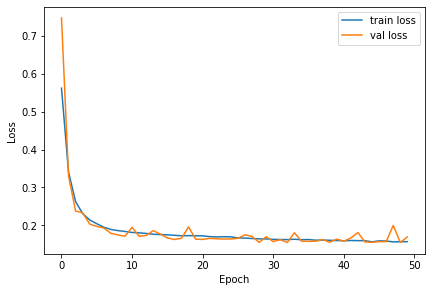

In [140]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history_qmodel.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history_qmodel.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [143]:
X_train_predict_qmodel = qmodel.predict(X_train)
X_test_predict_qmodel = qmodel.predict(X_test)
MC_zb_predict_qmodel = []
for i in range(len(MC_zb)):
    MC_zb_predict_qmodel.append(qmodel.predict(MC_zb[i]))

2022-05-31 01:48:52.742099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 01:49:30.738086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


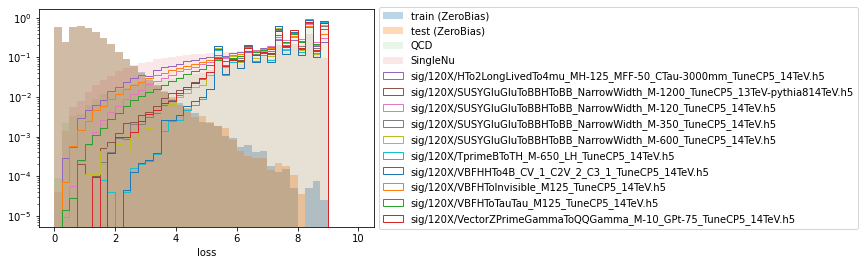

In [144]:
nbins = 40
rmin = 0
rmax = 10
plt.hist(X_train_predict_qmodel, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_predict_qmodel, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(MC_zb_predict_qmodel[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_zb_predict_qmodel[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(40,50):
    plt.hist(MC_zb_predict_qmodel[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# TensorBoard (less useful)

In [ ]:
%load_ext tensorboard
rm -rf ./logs/
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs/fit", histogram_freq = 1)
%tensorboard --logdir logs/fit

# ROC plotting

### Assigning labels and arranging for ROC plotting

In [145]:
#Baseline
#Assuming only the mean ZB is learned
#Take mean ZB as outputs no matter what inputs are
#Classifier of baseline = MSE(inputs, ZeroBias_mean)
ZeroBias_mean = np.mean(ZeroBias, axis = 0)

baseline_zb = np.mean((X_test - ZeroBias_mean)**2, axis = (1, 2))
baseline_mc = []
for i in range(len(MC_zb)):
    baseline_mc.append(np.mean((MC_zb[i] - ZeroBias_mean)**2, axis = (1, 2)))

In [146]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_mc = []
for i in range(len(MC)):
    Y_mc.append(np.ones((MC_zb[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. QCD/SingleNu/signals vs ZB

#True labels
Y_true = []
#Baseline scores
Y_baseline = []
#Model scores
Y_model = []
#Student model scores
Y_student = []
#Qmodel scores
Y_qmodel = []
for i in range(len(MC)):
    Y_true.append(np.concatenate((Y_mc[i], Y_zb)))
    Y_baseline.append(np.concatenate((baseline_mc[i], baseline_zb)))
    Y_model.append(np.concatenate((MC_zb_loss[i], X_test_loss)))
    Y_student.append(np.concatenate((MC_zb_predict_student[i], X_test_predict_student)))
    Y_qmodel.append(np.concatenate((MC_zb_predict_qmodel[i], X_test_predict_qmodel)))

### Baseline ROC

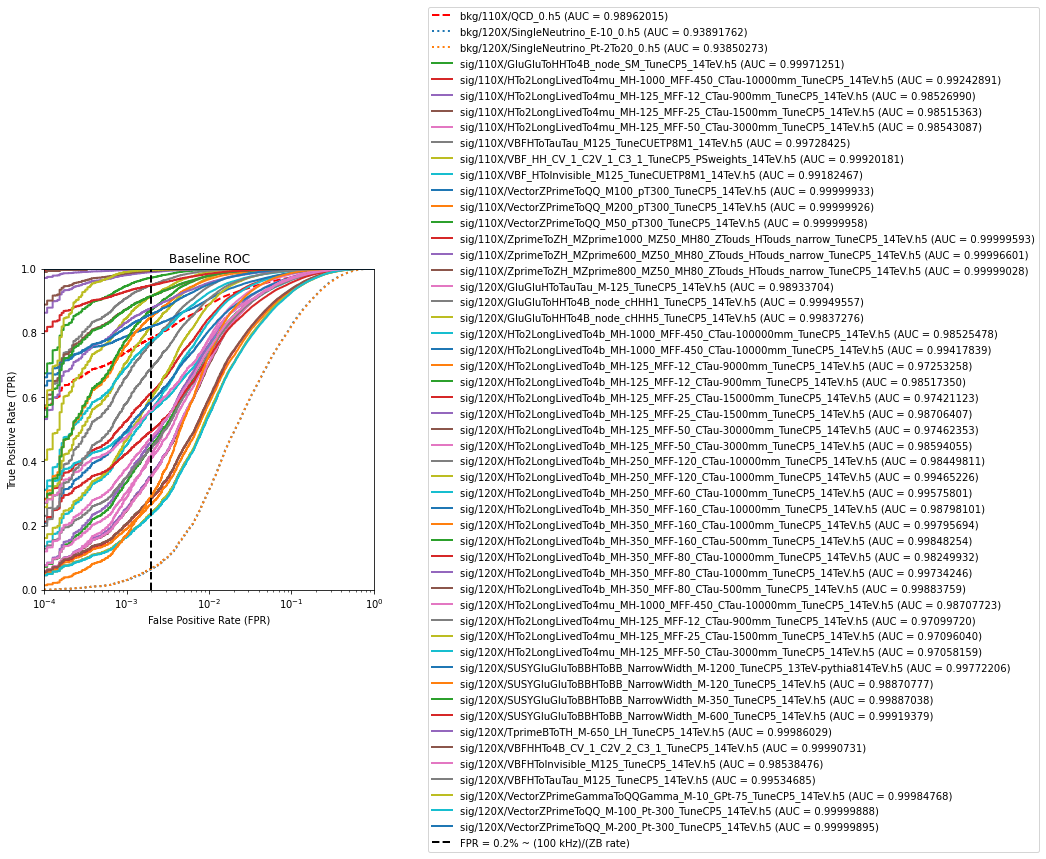

In [123]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_baseline = []
tpr_baseline = []
thresholds_baseline = []
roc_auc_baseline = []
for i in range(len(MC)):
    fpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    tpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_baseline.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_baseline.append(np.empty((Y_true[i].shape[0],1)))
    fpr_baseline[i], tpr_baseline[i], thresholds_baseline[i] = roc_curve(Y_true[i], Y_baseline[i])
    roc_auc_baseline[i] = auc(fpr_baseline[i], tpr_baseline[i])
    if i == 0:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
    else:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Baseline ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Teacher model ROC

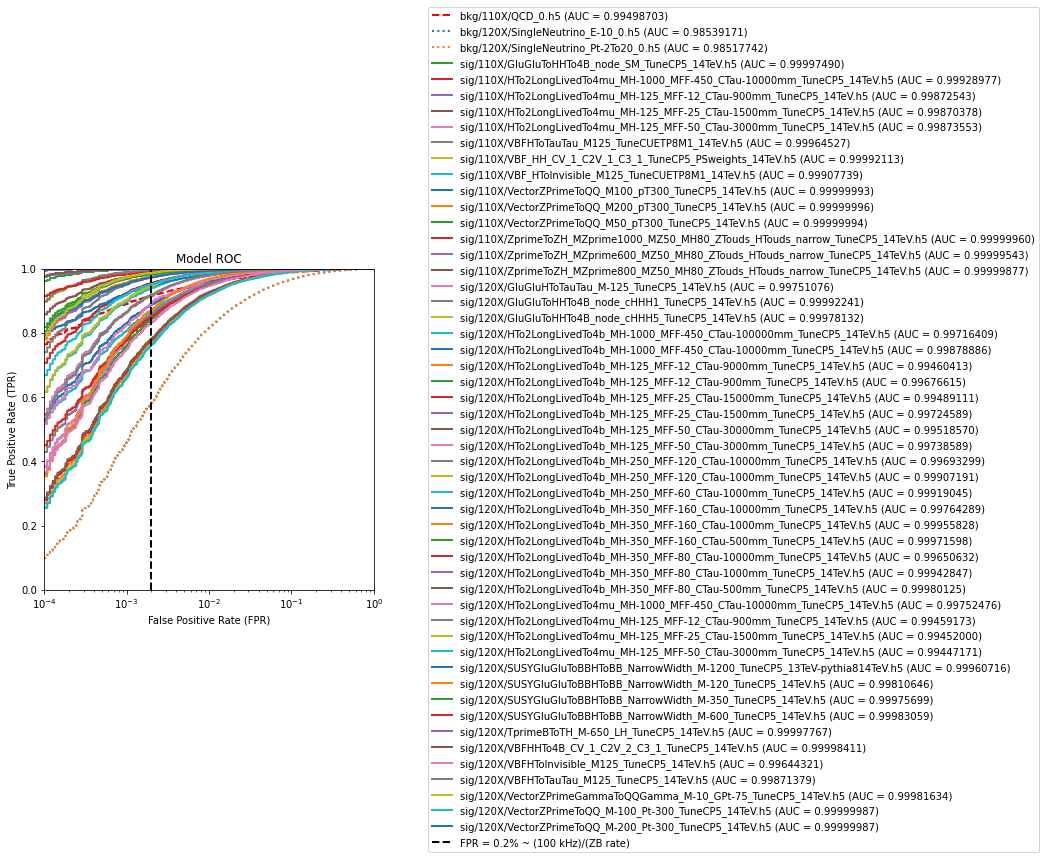

In [124]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_model = []
tpr_model = []
thresholds_model = []
roc_auc_model = []
for i in range(len(MC)):
    fpr_model.append(np.empty((Y_true[i].shape[0],1)))
    tpr_model.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_model.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_model.append(np.empty((Y_true[i].shape[0],1)))
    fpr_model[i], tpr_model[i], thresholds_model[i] = roc_curve(Y_true[i], Y_model[i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])
    if i == 0:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    else:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Model ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Student model ROC

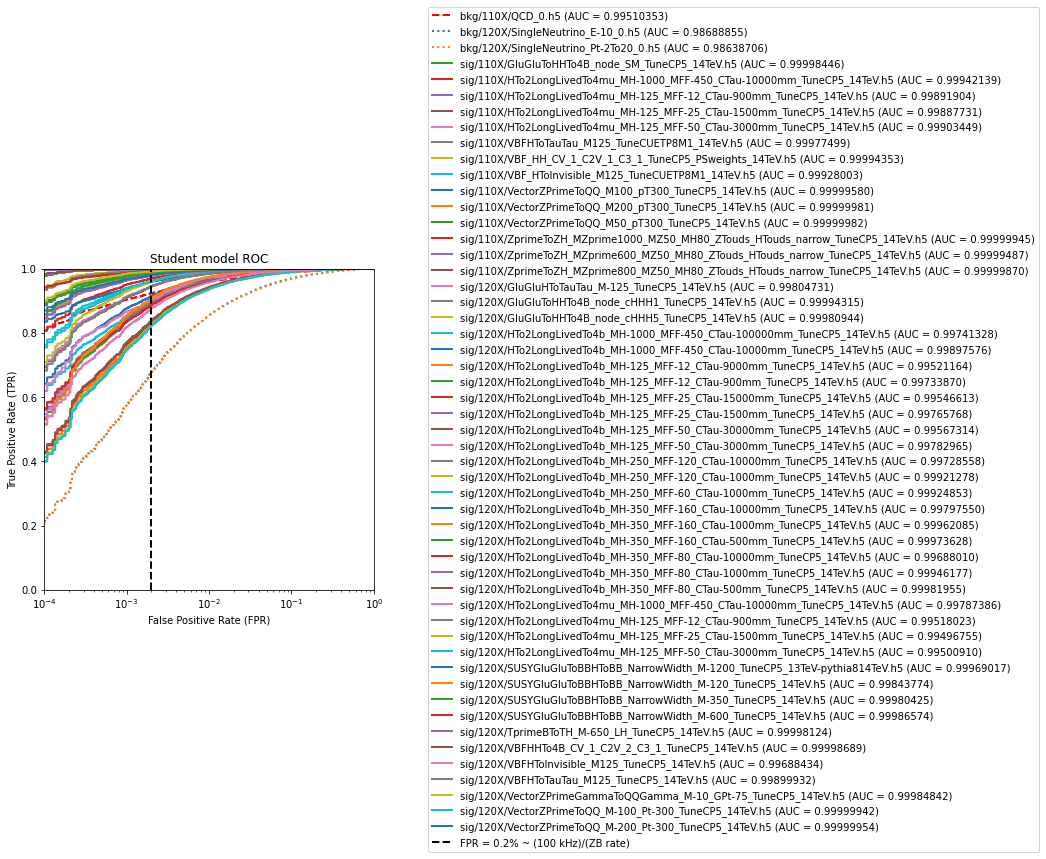

In [125]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_student = []
tpr_student = []
thresholds_student = []
roc_auc_student = []
for i in range(len(MC)):
    fpr_student.append(np.empty((Y_true[i].shape[0],1)))
    tpr_student.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_student.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_student.append(np.empty((Y_true[i].shape[0],1)))
    fpr_student[i], tpr_student[i], thresholds_student[i] = roc_curve(Y_true[i], Y_student[i])
    roc_auc_student[i] = auc(fpr_student[i], tpr_student[i])
    if i == 0:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
    else:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.1, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Student model ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

## Quantized student model ROC

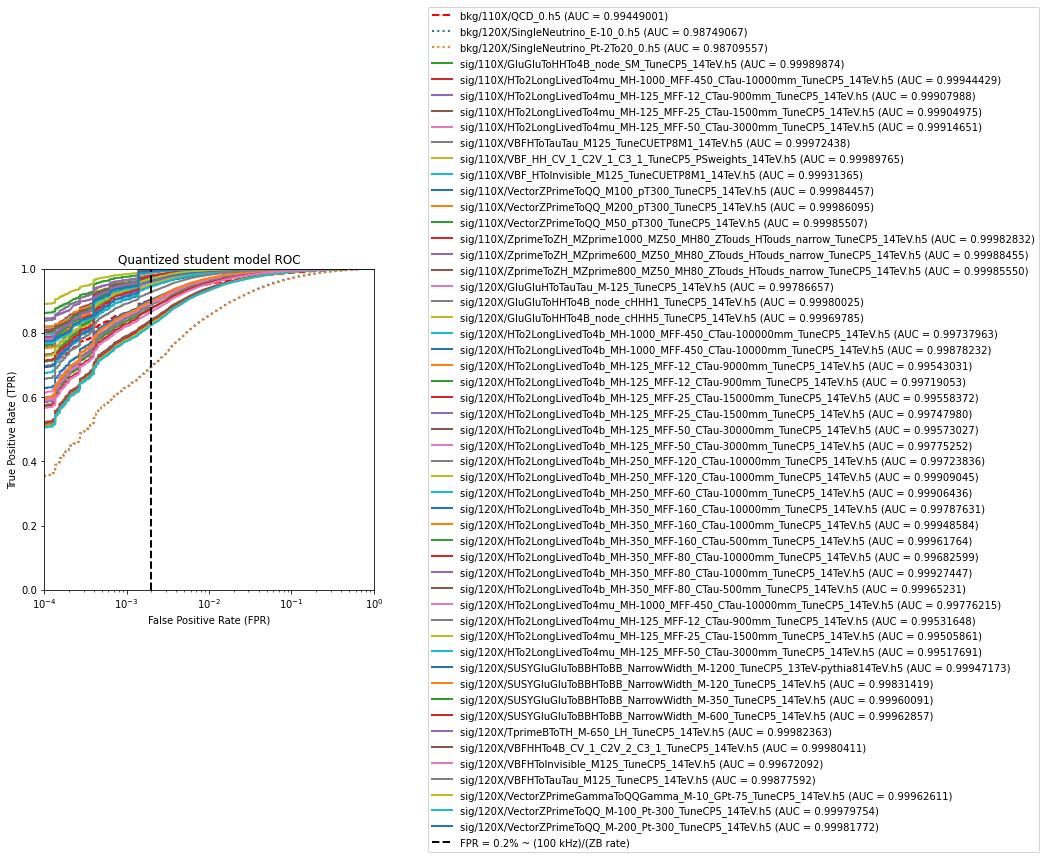

In [147]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_qmodel = []
tpr_qmodel = []
thresholds_qmodel = []
roc_auc_qmodel = []
for i in range(len(MC)):
    fpr_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    tpr_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    fpr_qmodel[i], tpr_qmodel[i], thresholds_qmodel[i] = roc_curve(Y_true[i], Y_qmodel[i])
    roc_auc_qmodel[i] = auc(fpr_qmodel[i], tpr_qmodel[i])
    if i == 0:
        axes.plot(fpr_qmodel[i], tpr_qmodel[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_qmodel[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_qmodel[i], tpr_qmodel[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_qmodel[i]))
    else:
        axes.plot(fpr_qmodel[i], tpr_qmodel[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_qmodel[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.1, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Quantized student model ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Tabulating TPR at fixed FPR = 0.2% (baseline, model, change).

In [148]:
table_tpr_baseline = []
table_tpr_model = []
table_tpr_student = []
table_tpr_qmodel = []
table_tpr_change = []
for i in range(len(fpr_baseline)):
    for j in range(len(fpr_baseline[i])):
        if fpr_baseline[i][j] > 0.002:
            table_tpr_baseline.append(tpr_baseline[i][j] * 100)
            break
    for j in range(len(fpr_model[i])):
        if fpr_model[i][j] > 0.002:
            table_tpr_model.append(tpr_model[i][j] * 100)
            break
    for j in range(len(fpr_student[i])):
        if fpr_student[i][j] > 0.002:
            table_tpr_student.append(tpr_student[i][j] * 100)
            break
    for j in range(len(fpr_qmodel[i])):
        if fpr_qmodel[i][j] > 0.002:
            table_tpr_qmodel.append(tpr_qmodel[i][j] * 100)
            break

for i in range(len(MC)):
    #table_tpr_change.append(100 * (table_tpr_model[i] - table_tpr_baseline[i])/table_tpr_baseline[i])
    table_tpr_change.append(-table_tpr_student[i] + table_tpr_qmodel[i])

table_tpr = pd.DataFrame({'Baseline': table_tpr_baseline,
                          'CNN AE (teacher)': table_tpr_model,
                          'Dense (student)': table_tpr_student,
                          'qDense (qstudent)': table_tpr_qmodel,
                          'delta(qDense, Dense)': table_tpr_change},
                        index = MC_files)
table_tpr = table_tpr.sort_values(by = 'delta(qDense, Dense)', ascending = False)

pd.set_option('display.max_colwidth', None)
table_tpr

,Baseline,CNN AE (teacher),Dense (student),qDense (qstudent),"delta(qDense, Dense)"
bkg/120X/SingleNeutrino_E-10_0.h5,6.539000,58.301000,67.767000,69.529000,1.762000
bkg/120X/SingleNeutrino_Pt-2To20_0.h5,6.671000,58.284000,67.657000,69.386000,1.729000
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5,35.847747,91.661364,94.409094,94.996240,0.587146
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5,35.227496,91.748869,94.441166,94.955456,0.514291
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5,23.871615,76.504514,82.438984,82.815112,0.376128
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5,23.924781,76.357445,82.293392,82.633904,0.340512
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5,35.369406,91.632095,94.571454,94.774473,0.203019
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5,23.483708,76.173310,82.210478,82.402968,0.192489
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5,28.630614,78.185151,83.871677,84.029331,0.157654
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5,28.471703,77.857321,83.791003,83.776757,-0.014247
